### This notebook is a tutorial for the PERT infer scRT module.

PERT takes binned read counts with called copy number states as input from scWGS. Cells are split into high-confidence G1/2-phase and unknown phase sets of cells before passing data into the probabilistic model.

Here, we are analyzing simulated data from 400 S-phase cells and 400 G1-phase cells with no CNAs. HMMcopy has been run on the simulated data to obtain the `copy` and `state` columns.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scdna_replication_tools.infer_scRT import scRT
from scdna_replication_tools.plot_pert_output import plot_model_results

    71618 Creating converter from 7 to 5


Creating converter from 7 to 5


    71622 Creating converter from 5 to 7


Creating converter from 5 to 7


    71623 Creating converter from 7 to 5


Creating converter from 7 to 5


    71625 Creating converter from 5 to 7


Creating converter from 5 to 7


    73490 Loaded backend module://ipykernel.pylab.backend_inline version unknown.


Loaded backend module://ipykernel.pylab.backend_inline version unknown.


In [2]:
# load the simulated data from the paper
# this corresponds to the data seen in simulated dataset 1.0
cn_s = pd.read_csv('notebooks/s_phase_cells_hmmcopy.csv.gz')
cn_g1 = pd.read_csv('notebooks/g1_phase_cells_hmmcopy.csv.gz')
cn_s.head()

,cell_id,chr,start,end,reads,gc,map,copy,state,multiplier,...,clone_cn_state,true_G1_state,library_id,true_reads_norm,true_reads_raw,true_rep,true_p_rep,true_t,observed_cn_state,true_cell_frac_rep
0,cell_S_0,1,2000000,2500000,428,0.594508,0.997066,1.690361,2,2,...,2.0,2.0,ABCD,228,428.0,0.0,0.525526,0.063202,2.0,0.083287
1,cell_S_0,1,4500000,5000000,357,0.481828,0.999002,1.900438,2,2,...,2.0,2.0,ABCD,190,357.0,0.0,0.001294,0.063202,2.0,0.083287
2,cell_S_0,1,6500000,7000000,389,0.489968,0.999179,2.027809,2,2,...,2.0,2.0,ABCD,207,389.0,0.0,0.399713,0.063202,2.0,0.083287
3,cell_S_0,1,7500000,8000000,395,0.488250,0.998566,2.068249,2,2,...,2.0,2.0,ABCD,211,395.0,0.0,0.198803,0.063202,2.0,0.083287
4,cell_S_0,1,8000000,8500000,337,0.462702,0.998576,1.883205,2,2,...,2.0,2.0,ABCD,180,337.0,0.0,0.265740,0.063202,2.0,0.083287


In [3]:
cn_g1.head()

,cell_id,chr,start,end,reads,gc,map,copy,state,multiplier,...,nhek_rt,bin_size,clone_id,clone_cn_state,true_G1_state,library_id,true_reads_norm,true_reads_raw,observed_cn_state,true_cell_frac_rep
0,cell_G_0,1,2000000,2500000,839,0.594508,0.997066,2.103612,2,2,...,72.161813,500000,A,2.0,2.0,ABCD,286,839.0,2.0,0.0
1,cell_G_0,1,4500000,5000000,594,0.481828,0.999002,1.897203,2,2,...,40.645100,500000,A,2.0,2.0,ABCD,202,594.0,2.0,0.0
2,cell_G_0,1,6500000,7000000,588,0.489968,0.999179,1.844981,2,2,...,67.336678,500000,A,2.0,2.0,ABCD,200,588.0,2.0,0.0
3,cell_G_0,1,7500000,8000000,632,0.488250,0.998566,1.990483,2,2,...,60.800801,500000,A,2.0,2.0,ABCD,215,632.0,2.0,0.0
4,cell_G_0,1,8000000,8500000,629,0.462702,0.998576,2.094786,2,2,...,70.025844,500000,A,2.0,2.0,ABCD,214,629.0,2.0,0.0


In [4]:
# add the replication columns for the G1-phase cells
cn_g1['true_rep'] = 0.0
cn_g1['true_p_rep'] = 0.0
cn_g1['true_t'] = 1.0

   153916 findfont: Matching sans\-serif:style=normal:variant=normal:weight=normal:stretch=normal:size=12.0.


findfont: Matching sans\-serif:style=normal:variant=normal:weight=normal:stretch=normal:size=12.0.


   153919 findfont: score(<Font 'DejaVu Sans Mono' (DejaVuSansMono.ttf) normal normal 400 normal>) = 10.05


findfont: score(<Font 'DejaVu Sans Mono' (DejaVuSansMono.ttf) normal normal 400 normal>) = 10.05


   153921 findfont: score(<Font 'STIXGeneral' (STIXGeneralBolIta.ttf) italic normal 700 normal>) = 11.335


findfont: score(<Font 'STIXGeneral' (STIXGeneralBolIta.ttf) italic normal 700 normal>) = 11.335


   153922 findfont: score(<Font 'cmr10' (cmr10.ttf) normal normal 400 normal>) = 10.05


findfont: score(<Font 'cmr10' (cmr10.ttf) normal normal 400 normal>) = 10.05


   153924 findfont: score(<Font 'STIXSizeFiveSym' (STIXSizFiveSymReg.ttf) normal normal 400 normal>) = 10.05


findfont: score(<Font 'STIXSizeFiveSym' (STIXSizFiveSymReg.ttf) normal normal 400 normal>) = 10.05


   153927 findfont: score(<Font 'STIXNonUnicode' (STIXNonUni.ttf) normal normal 400 normal>) = 10.05


findfont: score(<Font 'STIXNonUnicode' (STIXNonUni.ttf) normal normal 400 normal>) = 10.05


   153928 findfont: score(<Font 'STIXSizeFourSym' (STIXSizFourSymReg.ttf) normal normal 400 normal>) = 10.05


findfont: score(<Font 'STIXSizeFourSym' (STIXSizFourSymReg.ttf) normal normal 400 normal>) = 10.05


   153930 findfont: score(<Font 'cmex10' (cmex10.ttf) normal normal 400 normal>) = 10.05


findfont: score(<Font 'cmex10' (cmex10.ttf) normal normal 400 normal>) = 10.05


   153931 findfont: score(<Font 'STIXSizeTwoSym' (STIXSizTwoSymReg.ttf) normal normal 400 normal>) = 10.05


findfont: score(<Font 'STIXSizeTwoSym' (STIXSizTwoSymReg.ttf) normal normal 400 normal>) = 10.05


   153933 findfont: score(<Font 'STIXSizeFourSym' (STIXSizFourSymBol.ttf) normal normal 700 normal>) = 10.335


findfont: score(<Font 'STIXSizeFourSym' (STIXSizFourSymBol.ttf) normal normal 700 normal>) = 10.335


   153935 findfont: score(<Font 'cmsy10' (cmsy10.ttf) normal normal 400 normal>) = 10.05


findfont: score(<Font 'cmsy10' (cmsy10.ttf) normal normal 400 normal>) = 10.05


   153936 findfont: score(<Font 'cmss10' (cmss10.ttf) normal normal 400 normal>) = 10.05


findfont: score(<Font 'cmss10' (cmss10.ttf) normal normal 400 normal>) = 10.05


   153938 findfont: score(<Font 'cmb10' (cmb10.ttf) normal normal 400 normal>) = 10.05


findfont: score(<Font 'cmb10' (cmb10.ttf) normal normal 400 normal>) = 10.05


   153939 findfont: score(<Font 'DejaVu Serif Display' (DejaVuSerifDisplay.ttf) normal normal 400 normal>) = 10.05


findfont: score(<Font 'DejaVu Serif Display' (DejaVuSerifDisplay.ttf) normal normal 400 normal>) = 10.05


   153940 findfont: score(<Font 'DejaVu Sans' (DejaVuSans-Oblique.ttf) oblique normal 400 normal>) = 1.05


findfont: score(<Font 'DejaVu Sans' (DejaVuSans-Oblique.ttf) oblique normal 400 normal>) = 1.05


   153942 findfont: score(<Font 'DejaVu Sans' (DejaVuSans-BoldOblique.ttf) oblique normal 700 normal>) = 1.335


findfont: score(<Font 'DejaVu Sans' (DejaVuSans-BoldOblique.ttf) oblique normal 700 normal>) = 1.335


   153943 findfont: score(<Font 'DejaVu Serif' (DejaVuSerif.ttf) normal normal 400 normal>) = 10.05


findfont: score(<Font 'DejaVu Serif' (DejaVuSerif.ttf) normal normal 400 normal>) = 10.05


   153945 findfont: score(<Font 'cmmi10' (cmmi10.ttf) normal normal 400 normal>) = 10.05


findfont: score(<Font 'cmmi10' (cmmi10.ttf) normal normal 400 normal>) = 10.05


   153946 findfont: score(<Font 'DejaVu Sans Mono' (DejaVuSansMono-Bold.ttf) normal normal 700 normal>) = 10.335


findfont: score(<Font 'DejaVu Sans Mono' (DejaVuSansMono-Bold.ttf) normal normal 700 normal>) = 10.335


   153947 findfont: score(<Font 'STIXSizeOneSym' (STIXSizOneSymReg.ttf) normal normal 400 normal>) = 10.05


findfont: score(<Font 'STIXSizeOneSym' (STIXSizOneSymReg.ttf) normal normal 400 normal>) = 10.05


   153949 findfont: score(<Font 'DejaVu Sans' (DejaVuSans.ttf) normal normal 400 normal>) = 0.05


findfont: score(<Font 'DejaVu Sans' (DejaVuSans.ttf) normal normal 400 normal>) = 0.05


   153950 findfont: score(<Font 'DejaVu Sans Display' (DejaVuSansDisplay.ttf) normal normal 400 normal>) = 10.05


findfont: score(<Font 'DejaVu Sans Display' (DejaVuSansDisplay.ttf) normal normal 400 normal>) = 10.05


   153951 findfont: score(<Font 'STIXSizeThreeSym' (STIXSizThreeSymReg.ttf) normal normal 400 normal>) = 10.05


findfont: score(<Font 'STIXSizeThreeSym' (STIXSizThreeSymReg.ttf) normal normal 400 normal>) = 10.05


   153953 findfont: score(<Font 'STIXSizeThreeSym' (STIXSizThreeSymBol.ttf) normal normal 700 normal>) = 10.335


findfont: score(<Font 'STIXSizeThreeSym' (STIXSizThreeSymBol.ttf) normal normal 700 normal>) = 10.335


   153954 findfont: score(<Font 'DejaVu Serif' (DejaVuSerif-BoldItalic.ttf) italic normal 700 normal>) = 11.335


findfont: score(<Font 'DejaVu Serif' (DejaVuSerif-BoldItalic.ttf) italic normal 700 normal>) = 11.335


   153955 findfont: score(<Font 'STIXNonUnicode' (STIXNonUniIta.ttf) italic normal 400 normal>) = 11.05


findfont: score(<Font 'STIXNonUnicode' (STIXNonUniIta.ttf) italic normal 400 normal>) = 11.05


   153957 findfont: score(<Font 'DejaVu Sans' (DejaVuSans-Bold.ttf) normal normal 700 normal>) = 0.33499999999999996


findfont: score(<Font 'DejaVu Sans' (DejaVuSans-Bold.ttf) normal normal 700 normal>) = 0.33499999999999996


   153958 findfont: score(<Font 'cmtt10' (cmtt10.ttf) normal normal 400 normal>) = 10.05


findfont: score(<Font 'cmtt10' (cmtt10.ttf) normal normal 400 normal>) = 10.05


   153959 findfont: score(<Font 'DejaVu Sans Mono' (DejaVuSansMono-BoldOblique.ttf) oblique normal 700 normal>) = 11.335


findfont: score(<Font 'DejaVu Sans Mono' (DejaVuSansMono-BoldOblique.ttf) oblique normal 700 normal>) = 11.335


   153963 findfont: score(<Font 'STIXGeneral' (STIXGeneralItalic.ttf) italic normal 400 normal>) = 11.05


findfont: score(<Font 'STIXGeneral' (STIXGeneralItalic.ttf) italic normal 400 normal>) = 11.05


   153964 findfont: score(<Font 'DejaVu Sans Mono' (DejaVuSansMono-Oblique.ttf) oblique normal 400 normal>) = 11.05


findfont: score(<Font 'DejaVu Sans Mono' (DejaVuSansMono-Oblique.ttf) oblique normal 400 normal>) = 11.05


   153965 findfont: score(<Font 'STIXGeneral' (STIXGeneralBol.ttf) normal normal 700 normal>) = 10.335


findfont: score(<Font 'STIXGeneral' (STIXGeneralBol.ttf) normal normal 700 normal>) = 10.335


   153967 findfont: score(<Font 'STIXGeneral' (STIXGeneral.ttf) normal normal 400 normal>) = 10.05


findfont: score(<Font 'STIXGeneral' (STIXGeneral.ttf) normal normal 400 normal>) = 10.05


   153968 findfont: score(<Font 'STIXSizeTwoSym' (STIXSizTwoSymBol.ttf) normal normal 700 normal>) = 10.335


findfont: score(<Font 'STIXSizeTwoSym' (STIXSizTwoSymBol.ttf) normal normal 700 normal>) = 10.335


   153969 findfont: score(<Font 'STIXNonUnicode' (STIXNonUniBolIta.ttf) italic normal 700 normal>) = 11.335


findfont: score(<Font 'STIXNonUnicode' (STIXNonUniBolIta.ttf) italic normal 700 normal>) = 11.335


   153970 findfont: score(<Font 'DejaVu Serif' (DejaVuSerif-Italic.ttf) italic normal 400 normal>) = 11.05


findfont: score(<Font 'DejaVu Serif' (DejaVuSerif-Italic.ttf) italic normal 400 normal>) = 11.05


   153972 findfont: score(<Font 'STIXNonUnicode' (STIXNonUniBol.ttf) normal normal 700 normal>) = 10.335


findfont: score(<Font 'STIXNonUnicode' (STIXNonUniBol.ttf) normal normal 700 normal>) = 10.335


   153973 findfont: score(<Font 'STIXSizeOneSym' (STIXSizOneSymBol.ttf) normal normal 700 normal>) = 10.335


findfont: score(<Font 'STIXSizeOneSym' (STIXSizOneSymBol.ttf) normal normal 700 normal>) = 10.335


   153974 findfont: score(<Font 'DejaVu Serif' (DejaVuSerif-Bold.ttf) normal normal 700 normal>) = 10.335


findfont: score(<Font 'DejaVu Serif' (DejaVuSerif-Bold.ttf) normal normal 700 normal>) = 10.335


   153975 findfont: score(<Font 'Liberation Sans' (LiberationSans-Italic.ttf) italic normal 400 normal>) = 11.05


findfont: score(<Font 'Liberation Sans' (LiberationSans-Italic.ttf) italic normal 400 normal>) = 11.05


   153976 findfont: score(<Font 'Liberation Sans' (LiberationSans-Regular.ttf) normal normal 400 normal>) = 10.05


findfont: score(<Font 'Liberation Sans' (LiberationSans-Regular.ttf) normal normal 400 normal>) = 10.05


   153978 findfont: score(<Font 'DejaVu Sans' (DejaVuSans-Bold.ttf) normal normal 700 normal>) = 0.33499999999999996


findfont: score(<Font 'DejaVu Sans' (DejaVuSans-Bold.ttf) normal normal 700 normal>) = 0.33499999999999996


   153979 findfont: score(<Font 'DejaVu Sans Mono' (DejaVuSansMono-BoldOblique.ttf) oblique normal 700 normal>) = 11.335


findfont: score(<Font 'DejaVu Sans Mono' (DejaVuSansMono-BoldOblique.ttf) oblique normal 700 normal>) = 11.335


   153980 findfont: score(<Font 'STIX' (STIX-Regular.otf) normal normal 400 normal>) = 10.05


findfont: score(<Font 'STIX' (STIX-Regular.otf) normal normal 400 normal>) = 10.05


   153981 findfont: score(<Font 'DejaVu Sans' (DejaVuSans-BoldOblique.ttf) oblique normal 700 normal>) = 1.335


findfont: score(<Font 'DejaVu Sans' (DejaVuSans-BoldOblique.ttf) oblique normal 700 normal>) = 1.335


   153982 findfont: score(<Font 'DejaVu Sans' (DejaVuSansCondensed-Bold.ttf) normal normal 700 condensed>) = 0.5349999999999999


findfont: score(<Font 'DejaVu Sans' (DejaVuSansCondensed-Bold.ttf) normal normal 700 condensed>) = 0.5349999999999999


   153983 findfont: score(<Font 'STIX' (STIX-Bold.otf) normal normal 700 normal>) = 10.335


findfont: score(<Font 'STIX' (STIX-Bold.otf) normal normal 700 normal>) = 10.335


   153984 findfont: score(<Font 'DejaVu Sans' (DejaVuSansCondensed.ttf) normal normal 400 condensed>) = 0.25


findfont: score(<Font 'DejaVu Sans' (DejaVuSansCondensed.ttf) normal normal 400 condensed>) = 0.25


   153986 findfont: score(<Font 'DejaVu Sans' (DejaVuSansCondensed-Oblique.ttf) oblique normal 400 condensed>) = 1.25


findfont: score(<Font 'DejaVu Sans' (DejaVuSansCondensed-Oblique.ttf) oblique normal 400 condensed>) = 1.25


   153987 findfont: score(<Font 'DejaVu Sans' (DejaVuSans-ExtraLight.ttf) normal normal 200 normal>) = 0.24


findfont: score(<Font 'DejaVu Sans' (DejaVuSans-ExtraLight.ttf) normal normal 200 normal>) = 0.24


   153988 findfont: score(<Font 'Liberation Sans' (LiberationSans-Bold.ttf) normal normal 700 normal>) = 10.335


findfont: score(<Font 'Liberation Sans' (LiberationSans-Bold.ttf) normal normal 700 normal>) = 10.335


   153989 findfont: score(<Font 'DejaVu Sans' (DejaVuSans-Oblique.ttf) oblique normal 400 normal>) = 1.05


findfont: score(<Font 'DejaVu Sans' (DejaVuSans-Oblique.ttf) oblique normal 400 normal>) = 1.05


   153990 findfont: score(<Font 'DejaVu Sans' (DejaVuSans.ttf) normal normal 400 normal>) = 0.05


findfont: score(<Font 'DejaVu Sans' (DejaVuSans.ttf) normal normal 400 normal>) = 0.05


   153991 findfont: score(<Font 'STIX' (STIX-BoldItalic.otf) italic normal 700 normal>) = 11.335


findfont: score(<Font 'STIX' (STIX-BoldItalic.otf) italic normal 700 normal>) = 11.335


   153992 findfont: score(<Font 'DejaVu Sans Mono' (DejaVuSansMono-Bold.ttf) normal normal 700 normal>) = 10.335


findfont: score(<Font 'DejaVu Sans Mono' (DejaVuSansMono-Bold.ttf) normal normal 700 normal>) = 10.335


   153993 findfont: score(<Font 'DejaVu Sans' (DejaVuSansCondensed-BoldOblique.ttf) oblique normal 700 condensed>) = 1.535


findfont: score(<Font 'DejaVu Sans' (DejaVuSansCondensed-BoldOblique.ttf) oblique normal 700 condensed>) = 1.535


   153995 findfont: score(<Font 'DejaVu Sans Mono' (DejaVuSansMono.ttf) normal normal 400 normal>) = 10.05


findfont: score(<Font 'DejaVu Sans Mono' (DejaVuSansMono.ttf) normal normal 400 normal>) = 10.05


   153996 findfont: score(<Font 'DejaVu Sans Mono' (DejaVuSansMono-Oblique.ttf) oblique normal 400 normal>) = 11.05


findfont: score(<Font 'DejaVu Sans Mono' (DejaVuSansMono-Oblique.ttf) oblique normal 400 normal>) = 11.05


   153997 findfont: score(<Font 'STIX' (STIX-Italic.otf) italic normal 400 normal>) = 11.05


findfont: score(<Font 'STIX' (STIX-Italic.otf) italic normal 400 normal>) = 11.05


   153998 findfont: score(<Font 'Liberation Sans' (LiberationSans-BoldItalic.ttf) italic normal 700 normal>) = 11.335


findfont: score(<Font 'Liberation Sans' (LiberationSans-BoldItalic.ttf) italic normal 700 normal>) = 11.335


   153999 findfont: Matching sans\-serif:style=normal:variant=normal:weight=normal:stretch=normal:size=12.0 to DejaVu Sans ('/juno/work/shah/users/weinera2/projects/scdna_replication_tools/venv/lib/python3.7/site-packages/matplotlib/mpl-data/fonts/ttf/DejaVuSans.ttf') with score of 0.050000.


findfont: Matching sans\-serif:style=normal:variant=normal:weight=normal:stretch=normal:size=12.0 to DejaVu Sans ('/juno/work/shah/users/weinera2/projects/scdna_replication_tools/venv/lib/python3.7/site-packages/matplotlib/mpl-data/fonts/ttf/DejaVuSans.ttf') with score of 0.050000.


   154076 findfont: Matching sans\-serif:style=normal:variant=normal:weight=normal:stretch=normal:size=10.0.


findfont: Matching sans\-serif:style=normal:variant=normal:weight=normal:stretch=normal:size=10.0.


   154078 findfont: score(<Font 'DejaVu Sans Mono' (DejaVuSansMono.ttf) normal normal 400 normal>) = 10.05


findfont: score(<Font 'DejaVu Sans Mono' (DejaVuSansMono.ttf) normal normal 400 normal>) = 10.05


   154079 findfont: score(<Font 'STIXGeneral' (STIXGeneralBolIta.ttf) italic normal 700 normal>) = 11.335


findfont: score(<Font 'STIXGeneral' (STIXGeneralBolIta.ttf) italic normal 700 normal>) = 11.335


   154081 findfont: score(<Font 'cmr10' (cmr10.ttf) normal normal 400 normal>) = 10.05


findfont: score(<Font 'cmr10' (cmr10.ttf) normal normal 400 normal>) = 10.05


   154082 findfont: score(<Font 'STIXSizeFiveSym' (STIXSizFiveSymReg.ttf) normal normal 400 normal>) = 10.05


findfont: score(<Font 'STIXSizeFiveSym' (STIXSizFiveSymReg.ttf) normal normal 400 normal>) = 10.05


   154084 findfont: score(<Font 'STIXNonUnicode' (STIXNonUni.ttf) normal normal 400 normal>) = 10.05


findfont: score(<Font 'STIXNonUnicode' (STIXNonUni.ttf) normal normal 400 normal>) = 10.05


   154085 findfont: score(<Font 'STIXSizeFourSym' (STIXSizFourSymReg.ttf) normal normal 400 normal>) = 10.05


findfont: score(<Font 'STIXSizeFourSym' (STIXSizFourSymReg.ttf) normal normal 400 normal>) = 10.05


   154087 findfont: score(<Font 'cmex10' (cmex10.ttf) normal normal 400 normal>) = 10.05


findfont: score(<Font 'cmex10' (cmex10.ttf) normal normal 400 normal>) = 10.05


   154088 findfont: score(<Font 'STIXSizeTwoSym' (STIXSizTwoSymReg.ttf) normal normal 400 normal>) = 10.05


findfont: score(<Font 'STIXSizeTwoSym' (STIXSizTwoSymReg.ttf) normal normal 400 normal>) = 10.05


   154089 findfont: score(<Font 'STIXSizeFourSym' (STIXSizFourSymBol.ttf) normal normal 700 normal>) = 10.335


findfont: score(<Font 'STIXSizeFourSym' (STIXSizFourSymBol.ttf) normal normal 700 normal>) = 10.335


   154091 findfont: score(<Font 'cmsy10' (cmsy10.ttf) normal normal 400 normal>) = 10.05


findfont: score(<Font 'cmsy10' (cmsy10.ttf) normal normal 400 normal>) = 10.05


   154092 findfont: score(<Font 'cmss10' (cmss10.ttf) normal normal 400 normal>) = 10.05


findfont: score(<Font 'cmss10' (cmss10.ttf) normal normal 400 normal>) = 10.05


   154093 findfont: score(<Font 'cmb10' (cmb10.ttf) normal normal 400 normal>) = 10.05


findfont: score(<Font 'cmb10' (cmb10.ttf) normal normal 400 normal>) = 10.05


   154095 findfont: score(<Font 'DejaVu Serif Display' (DejaVuSerifDisplay.ttf) normal normal 400 normal>) = 10.05


findfont: score(<Font 'DejaVu Serif Display' (DejaVuSerifDisplay.ttf) normal normal 400 normal>) = 10.05


   154096 findfont: score(<Font 'DejaVu Sans' (DejaVuSans-Oblique.ttf) oblique normal 400 normal>) = 1.05


findfont: score(<Font 'DejaVu Sans' (DejaVuSans-Oblique.ttf) oblique normal 400 normal>) = 1.05


   154098 findfont: score(<Font 'DejaVu Sans' (DejaVuSans-BoldOblique.ttf) oblique normal 700 normal>) = 1.335


findfont: score(<Font 'DejaVu Sans' (DejaVuSans-BoldOblique.ttf) oblique normal 700 normal>) = 1.335


   154099 findfont: score(<Font 'DejaVu Serif' (DejaVuSerif.ttf) normal normal 400 normal>) = 10.05


findfont: score(<Font 'DejaVu Serif' (DejaVuSerif.ttf) normal normal 400 normal>) = 10.05


   154100 findfont: score(<Font 'cmmi10' (cmmi10.ttf) normal normal 400 normal>) = 10.05


findfont: score(<Font 'cmmi10' (cmmi10.ttf) normal normal 400 normal>) = 10.05


   154102 findfont: score(<Font 'DejaVu Sans Mono' (DejaVuSansMono-Bold.ttf) normal normal 700 normal>) = 10.335


findfont: score(<Font 'DejaVu Sans Mono' (DejaVuSansMono-Bold.ttf) normal normal 700 normal>) = 10.335


   154103 findfont: score(<Font 'STIXSizeOneSym' (STIXSizOneSymReg.ttf) normal normal 400 normal>) = 10.05


findfont: score(<Font 'STIXSizeOneSym' (STIXSizOneSymReg.ttf) normal normal 400 normal>) = 10.05


   154104 findfont: score(<Font 'DejaVu Sans' (DejaVuSans.ttf) normal normal 400 normal>) = 0.05


findfont: score(<Font 'DejaVu Sans' (DejaVuSans.ttf) normal normal 400 normal>) = 0.05


   154105 findfont: score(<Font 'DejaVu Sans Display' (DejaVuSansDisplay.ttf) normal normal 400 normal>) = 10.05


findfont: score(<Font 'DejaVu Sans Display' (DejaVuSansDisplay.ttf) normal normal 400 normal>) = 10.05


   154107 findfont: score(<Font 'STIXSizeThreeSym' (STIXSizThreeSymReg.ttf) normal normal 400 normal>) = 10.05


findfont: score(<Font 'STIXSizeThreeSym' (STIXSizThreeSymReg.ttf) normal normal 400 normal>) = 10.05


   154108 findfont: score(<Font 'STIXSizeThreeSym' (STIXSizThreeSymBol.ttf) normal normal 700 normal>) = 10.335


findfont: score(<Font 'STIXSizeThreeSym' (STIXSizThreeSymBol.ttf) normal normal 700 normal>) = 10.335


   154109 findfont: score(<Font 'DejaVu Serif' (DejaVuSerif-BoldItalic.ttf) italic normal 700 normal>) = 11.335


findfont: score(<Font 'DejaVu Serif' (DejaVuSerif-BoldItalic.ttf) italic normal 700 normal>) = 11.335


   154111 findfont: score(<Font 'STIXNonUnicode' (STIXNonUniIta.ttf) italic normal 400 normal>) = 11.05


findfont: score(<Font 'STIXNonUnicode' (STIXNonUniIta.ttf) italic normal 400 normal>) = 11.05


   154112 findfont: score(<Font 'DejaVu Sans' (DejaVuSans-Bold.ttf) normal normal 700 normal>) = 0.33499999999999996


findfont: score(<Font 'DejaVu Sans' (DejaVuSans-Bold.ttf) normal normal 700 normal>) = 0.33499999999999996


   154113 findfont: score(<Font 'cmtt10' (cmtt10.ttf) normal normal 400 normal>) = 10.05


findfont: score(<Font 'cmtt10' (cmtt10.ttf) normal normal 400 normal>) = 10.05


   154114 findfont: score(<Font 'DejaVu Sans Mono' (DejaVuSansMono-BoldOblique.ttf) oblique normal 700 normal>) = 11.335


findfont: score(<Font 'DejaVu Sans Mono' (DejaVuSansMono-BoldOblique.ttf) oblique normal 700 normal>) = 11.335


   154115 findfont: score(<Font 'STIXGeneral' (STIXGeneralItalic.ttf) italic normal 400 normal>) = 11.05


findfont: score(<Font 'STIXGeneral' (STIXGeneralItalic.ttf) italic normal 400 normal>) = 11.05


   154117 findfont: score(<Font 'DejaVu Sans Mono' (DejaVuSansMono-Oblique.ttf) oblique normal 400 normal>) = 11.05


findfont: score(<Font 'DejaVu Sans Mono' (DejaVuSansMono-Oblique.ttf) oblique normal 400 normal>) = 11.05


   154118 findfont: score(<Font 'STIXGeneral' (STIXGeneralBol.ttf) normal normal 700 normal>) = 10.335


findfont: score(<Font 'STIXGeneral' (STIXGeneralBol.ttf) normal normal 700 normal>) = 10.335


   154119 findfont: score(<Font 'STIXGeneral' (STIXGeneral.ttf) normal normal 400 normal>) = 10.05


findfont: score(<Font 'STIXGeneral' (STIXGeneral.ttf) normal normal 400 normal>) = 10.05


   154120 findfont: score(<Font 'STIXSizeTwoSym' (STIXSizTwoSymBol.ttf) normal normal 700 normal>) = 10.335


findfont: score(<Font 'STIXSizeTwoSym' (STIXSizTwoSymBol.ttf) normal normal 700 normal>) = 10.335


   154122 findfont: score(<Font 'STIXNonUnicode' (STIXNonUniBolIta.ttf) italic normal 700 normal>) = 11.335


findfont: score(<Font 'STIXNonUnicode' (STIXNonUniBolIta.ttf) italic normal 700 normal>) = 11.335


   154123 findfont: score(<Font 'DejaVu Serif' (DejaVuSerif-Italic.ttf) italic normal 400 normal>) = 11.05


findfont: score(<Font 'DejaVu Serif' (DejaVuSerif-Italic.ttf) italic normal 400 normal>) = 11.05


   154124 findfont: score(<Font 'STIXNonUnicode' (STIXNonUniBol.ttf) normal normal 700 normal>) = 10.335


findfont: score(<Font 'STIXNonUnicode' (STIXNonUniBol.ttf) normal normal 700 normal>) = 10.335


   154125 findfont: score(<Font 'STIXSizeOneSym' (STIXSizOneSymBol.ttf) normal normal 700 normal>) = 10.335


findfont: score(<Font 'STIXSizeOneSym' (STIXSizOneSymBol.ttf) normal normal 700 normal>) = 10.335


   154126 findfont: score(<Font 'DejaVu Serif' (DejaVuSerif-Bold.ttf) normal normal 700 normal>) = 10.335


findfont: score(<Font 'DejaVu Serif' (DejaVuSerif-Bold.ttf) normal normal 700 normal>) = 10.335


   154128 findfont: score(<Font 'Liberation Sans' (LiberationSans-Italic.ttf) italic normal 400 normal>) = 11.05


findfont: score(<Font 'Liberation Sans' (LiberationSans-Italic.ttf) italic normal 400 normal>) = 11.05


   154129 findfont: score(<Font 'Liberation Sans' (LiberationSans-Regular.ttf) normal normal 400 normal>) = 10.05


findfont: score(<Font 'Liberation Sans' (LiberationSans-Regular.ttf) normal normal 400 normal>) = 10.05


   154130 findfont: score(<Font 'DejaVu Sans' (DejaVuSans-Bold.ttf) normal normal 700 normal>) = 0.33499999999999996


findfont: score(<Font 'DejaVu Sans' (DejaVuSans-Bold.ttf) normal normal 700 normal>) = 0.33499999999999996


   154131 findfont: score(<Font 'DejaVu Sans Mono' (DejaVuSansMono-BoldOblique.ttf) oblique normal 700 normal>) = 11.335


findfont: score(<Font 'DejaVu Sans Mono' (DejaVuSansMono-BoldOblique.ttf) oblique normal 700 normal>) = 11.335


   154132 findfont: score(<Font 'STIX' (STIX-Regular.otf) normal normal 400 normal>) = 10.05


findfont: score(<Font 'STIX' (STIX-Regular.otf) normal normal 400 normal>) = 10.05


   154133 findfont: score(<Font 'DejaVu Sans' (DejaVuSans-BoldOblique.ttf) oblique normal 700 normal>) = 1.335


findfont: score(<Font 'DejaVu Sans' (DejaVuSans-BoldOblique.ttf) oblique normal 700 normal>) = 1.335


   154135 findfont: score(<Font 'DejaVu Sans' (DejaVuSansCondensed-Bold.ttf) normal normal 700 condensed>) = 0.5349999999999999


findfont: score(<Font 'DejaVu Sans' (DejaVuSansCondensed-Bold.ttf) normal normal 700 condensed>) = 0.5349999999999999


   154136 findfont: score(<Font 'STIX' (STIX-Bold.otf) normal normal 700 normal>) = 10.335


findfont: score(<Font 'STIX' (STIX-Bold.otf) normal normal 700 normal>) = 10.335


   154137 findfont: score(<Font 'DejaVu Sans' (DejaVuSansCondensed.ttf) normal normal 400 condensed>) = 0.25


findfont: score(<Font 'DejaVu Sans' (DejaVuSansCondensed.ttf) normal normal 400 condensed>) = 0.25


   154138 findfont: score(<Font 'DejaVu Sans' (DejaVuSansCondensed-Oblique.ttf) oblique normal 400 condensed>) = 1.25


findfont: score(<Font 'DejaVu Sans' (DejaVuSansCondensed-Oblique.ttf) oblique normal 400 condensed>) = 1.25


   154139 findfont: score(<Font 'DejaVu Sans' (DejaVuSans-ExtraLight.ttf) normal normal 200 normal>) = 0.24


findfont: score(<Font 'DejaVu Sans' (DejaVuSans-ExtraLight.ttf) normal normal 200 normal>) = 0.24


   154141 findfont: score(<Font 'Liberation Sans' (LiberationSans-Bold.ttf) normal normal 700 normal>) = 10.335


findfont: score(<Font 'Liberation Sans' (LiberationSans-Bold.ttf) normal normal 700 normal>) = 10.335


   154142 findfont: score(<Font 'DejaVu Sans' (DejaVuSans-Oblique.ttf) oblique normal 400 normal>) = 1.05


findfont: score(<Font 'DejaVu Sans' (DejaVuSans-Oblique.ttf) oblique normal 400 normal>) = 1.05


   154143 findfont: score(<Font 'DejaVu Sans' (DejaVuSans.ttf) normal normal 400 normal>) = 0.05


findfont: score(<Font 'DejaVu Sans' (DejaVuSans.ttf) normal normal 400 normal>) = 0.05


   154144 findfont: score(<Font 'STIX' (STIX-BoldItalic.otf) italic normal 700 normal>) = 11.335


findfont: score(<Font 'STIX' (STIX-BoldItalic.otf) italic normal 700 normal>) = 11.335


   154145 findfont: score(<Font 'DejaVu Sans Mono' (DejaVuSansMono-Bold.ttf) normal normal 700 normal>) = 10.335


findfont: score(<Font 'DejaVu Sans Mono' (DejaVuSansMono-Bold.ttf) normal normal 700 normal>) = 10.335


   154146 findfont: score(<Font 'DejaVu Sans' (DejaVuSansCondensed-BoldOblique.ttf) oblique normal 700 condensed>) = 1.535


findfont: score(<Font 'DejaVu Sans' (DejaVuSansCondensed-BoldOblique.ttf) oblique normal 700 condensed>) = 1.535


   154147 findfont: score(<Font 'DejaVu Sans Mono' (DejaVuSansMono.ttf) normal normal 400 normal>) = 10.05


findfont: score(<Font 'DejaVu Sans Mono' (DejaVuSansMono.ttf) normal normal 400 normal>) = 10.05


   154148 findfont: score(<Font 'DejaVu Sans Mono' (DejaVuSansMono-Oblique.ttf) oblique normal 400 normal>) = 11.05


findfont: score(<Font 'DejaVu Sans Mono' (DejaVuSansMono-Oblique.ttf) oblique normal 400 normal>) = 11.05


   154149 findfont: score(<Font 'STIX' (STIX-Italic.otf) italic normal 400 normal>) = 11.05


findfont: score(<Font 'STIX' (STIX-Italic.otf) italic normal 400 normal>) = 11.05


   154151 findfont: score(<Font 'Liberation Sans' (LiberationSans-BoldItalic.ttf) italic normal 700 normal>) = 11.335


findfont: score(<Font 'Liberation Sans' (LiberationSans-BoldItalic.ttf) italic normal 700 normal>) = 11.335


   154152 findfont: Matching sans\-serif:style=normal:variant=normal:weight=normal:stretch=normal:size=10.0 to DejaVu Sans ('/juno/work/shah/users/weinera2/projects/scdna_replication_tools/venv/lib/python3.7/site-packages/matplotlib/mpl-data/fonts/ttf/DejaVuSans.ttf') with score of 0.050000.


findfont: Matching sans\-serif:style=normal:variant=normal:weight=normal:stretch=normal:size=10.0 to DejaVu Sans ('/juno/work/shah/users/weinera2/projects/scdna_replication_tools/venv/lib/python3.7/site-packages/matplotlib/mpl-data/fonts/ttf/DejaVuSans.ttf') with score of 0.050000.


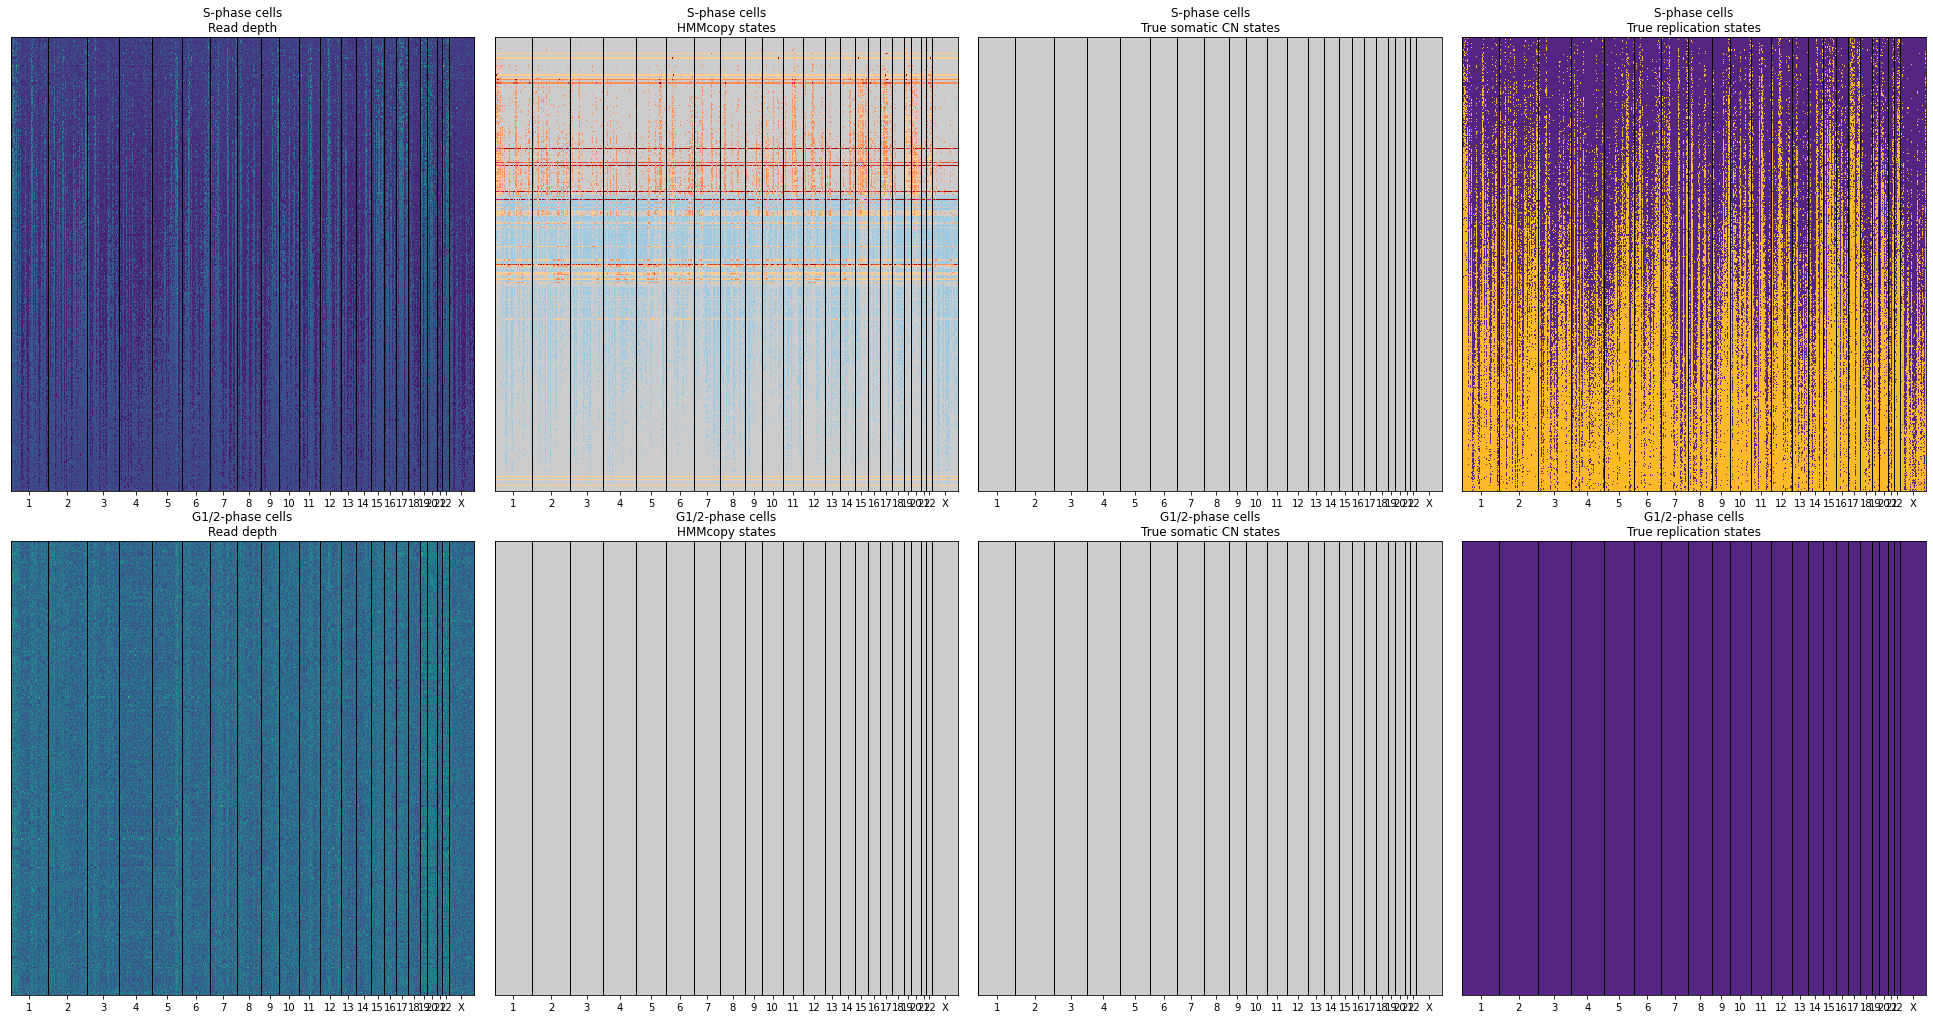

In [5]:
# plot the true simulated data
plot_model_results(
    cn_s, cn_g1, clone_col='clone_id', second_sort_col='true_t', 
    input_cn_col='state', output_cn_col='true_G1_state', 
    output_rep_col='true_rep', rpm_col='true_reads_norm',
    rpm_title='Read depth', input_cn_title='HMMcopy states',
    output_cn_title='True somatic CN states', rep_title='True replication states'
)
plt.show()

In the above plots, note how the HMMcopy `state` column accurately reflects somatic CN for G1/2-phase cells but not S-phase cells. This is because the HMMcopy model is not designed to handle the high copy number of S-phase cells. Given that replication origins are disproportionately located in high GC regions, some of the replication signal gets regressed out during per-cell GC normalization (1st step of hmmcopy). Thus, many replicated vs unreplicated bins in S-phase cells don't have clear 2:1 ratios, leading HMMcopy to select an erroneously high ploidy multiplier (2nd step of hmmcopy). Even if the ploidy multiplier is correct, the HMMcopy states only reflect the replicated signal that remains after GC normalization, so the states should be ignored in S-phase cells.

### Now we will run PERT to jointly infer scRT and CN states for all cells.

We are going to limit this example to just chromosomes 1-3 to speed up the analysis. We will also use a small number of iterations to speed up the analysis. In practice, we recommend using >1000 iterations and all chromosomes. One can also adjust the `learning_rate` and `rel_tol` away from default values of 0.05 and 1e-6, respectively, to achieve a desired optimization routine.

In [6]:
# temporarily remove columns that don't get used by PERT
temp_cn_s = cn_s[['cell_id', 'chr', 'start', 'end', 'gc', 'state', 'library_id', 'true_reads_norm']]
temp_cn_g1 = cn_g1[['cell_id', 'chr', 'start', 'end', 'gc', 'clone_id', 'state', 'library_id', 'true_reads_norm']]

# subset to only include chromosomes 1-3 for speed
temp_cn_s = temp_cn_s[(temp_cn_s['chr'] == '1') | (temp_cn_s['chr'] == '2') | (temp_cn_s['chr'] == '3')]
temp_cn_g1 = temp_cn_g1[(temp_cn_g1['chr'] == '1') | (temp_cn_g1['chr'] == '2') | (temp_cn_g1['chr'] == '3')]
print('number of cells in S-phase: ', len(temp_cn_s['cell_id'].unique()))
print('number of cells in G1-phase: ', len(temp_cn_g1['cell_id'].unique()))
print('number of loci in S-phase: ', len(temp_cn_s[['chr', 'start']].drop_duplicates()))
print('number of loci in G1-phase: ', len(temp_cn_g1[['chr', 'start']].drop_duplicates()))

number of cells in S-phase:  400
number of cells in G1-phase:  400
number of loci in S-phase:  752
number of loci in G1-phase:  752


In [7]:
%%capture

# create scRT object with input columns denoted
scrt = scRT(temp_cn_s, temp_cn_g1, input_col='true_reads_norm', clone_col='clone_id', assign_col='state', rt_prior_col=None,
            cn_state_col='state', gc_col='gc', cn_prior_method='g1_clones', max_iter=200)

# run inference using PERT
cn_s_with_scrt, supp_s_output, cn_g_with_scrt, supp_g_output = scrt.infer(level='pyro')

   163789 Loading data
   163791 ----------------------------------------
   224583 STEP 1: Learning reads to CN bias from low variance cells.
   224912 step: 0, loss: 2260231.25
   225014 step: 1, loss: 224952176.0
   226199 step: 2, loss: 11673388.0
   226220 step: 3, loss: 46661940.0
   226234 step: 4, loss: 95415440.0
   226248 step: 5, loss: 56251816.0
   226260 step: 6, loss: 10349174.0
   226272 step: 7, loss: 3783910.0
   226285 step: 8, loss: 20531318.0
   226297 step: 9, loss: 27975314.0
   226308 step: 10, loss: 18403214.0
   226319 step: 11, loss: 5652177.0
   226330 step: 12, loss: 1540473.375
   226342 step: 13, loss: 5279362.0
   226354 step: 14, loss: 8997664.0
   226365 step: 15, loss: 7956827.0
   226376 step: 16, loss: 4077273.5
   226387 step: 17, loss: 1588963.375
   226398 step: 18, loss: 1986079.25
   226409 step: 19, loss: 3441965.5
   226420 step: 20, loss: 3742165.5
   226430 step: 21, loss: 2684840.5
   226439 step: 22, loss: 1621348.75
   226449 step: 23, lo

In [8]:
cn_s_with_scrt.head()

,cell_id,chr,start,end,gc,state,library_id,true_reads_norm,clone_id,model_cn_state,model_rep_state,model_tau,model_u,model_rho
0,cell_S_0,1,2000000,2500000,0.594508,2,ABCD,228,A,2,0.0,0.114100,78.917603,0.135369
1,cell_S_1,1,2000000,2500000,0.594508,2,ABCD,184,A,2,0.0,0.138488,85.659935,0.135369
2,cell_S_10,1,2000000,2500000,0.594508,3,ABCD,379,A,2,1.0,0.213584,79.543076,0.135369
3,cell_S_100,1,2000000,2500000,0.594508,2,ABCD,171,A,2,1.0,0.764787,57.106892,0.135369
4,cell_S_101,1,2000000,2500000,0.594508,2,ABCD,297,A,2,1.0,0.576195,54.740360,0.135369


In [9]:
cn_g_with_scrt.head()

,cell_id,chr,start,end,gc,clone_id,state,library_id,true_reads_norm,model_cn_state,model_rep_state,model_tau,model_u,model_rho
0,cell_G_0,1,2000000,2500000,0.594508,A,2,ABCD,286,3,1.0,0.875102,61.331284,0.135369
1,cell_G_1,1,2000000,2500000,0.594508,A,2,ABCD,247,2,1.0,0.901003,56.611397,0.135369
2,cell_G_10,1,2000000,2500000,0.594508,A,2,ABCD,244,2,1.0,0.890071,59.324570,0.135369
3,cell_G_100,1,2000000,2500000,0.594508,A,2,ABCD,254,2,0.0,0.057768,69.010178,0.135369
4,cell_G_101,1,2000000,2500000,0.594508,A,2,ABCD,233,2,1.0,0.891375,58.503582,0.135369


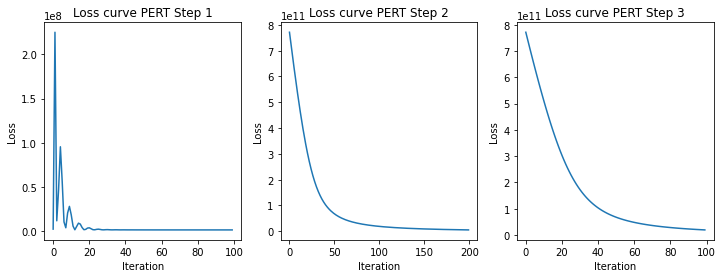

In [10]:
# plot the loss curve for 'loss_s' and 'loss_g' param values in the supp_s_output and supp_g_output dataframes
fig, ax = plt.subplots(1, 3, figsize=(12, 4))
sns.lineplot(data=supp_s_output.query("param=='loss_g'"), x='level', y='value', ax=ax[0])
sns.lineplot(data=supp_s_output.query("param=='loss_s'"), x='level', y='value', ax=ax[1])
sns.lineplot(data=supp_g_output.query("param=='loss_s'"), x='level', y='value', ax=ax[2])

for i in range(3):
    ax[i].set_xlabel('Iteration')
    ax[i].set_ylabel('Loss')
    ax[i].set_title('Loss curve PERT Step {}'.format(i+1))

plt.show()

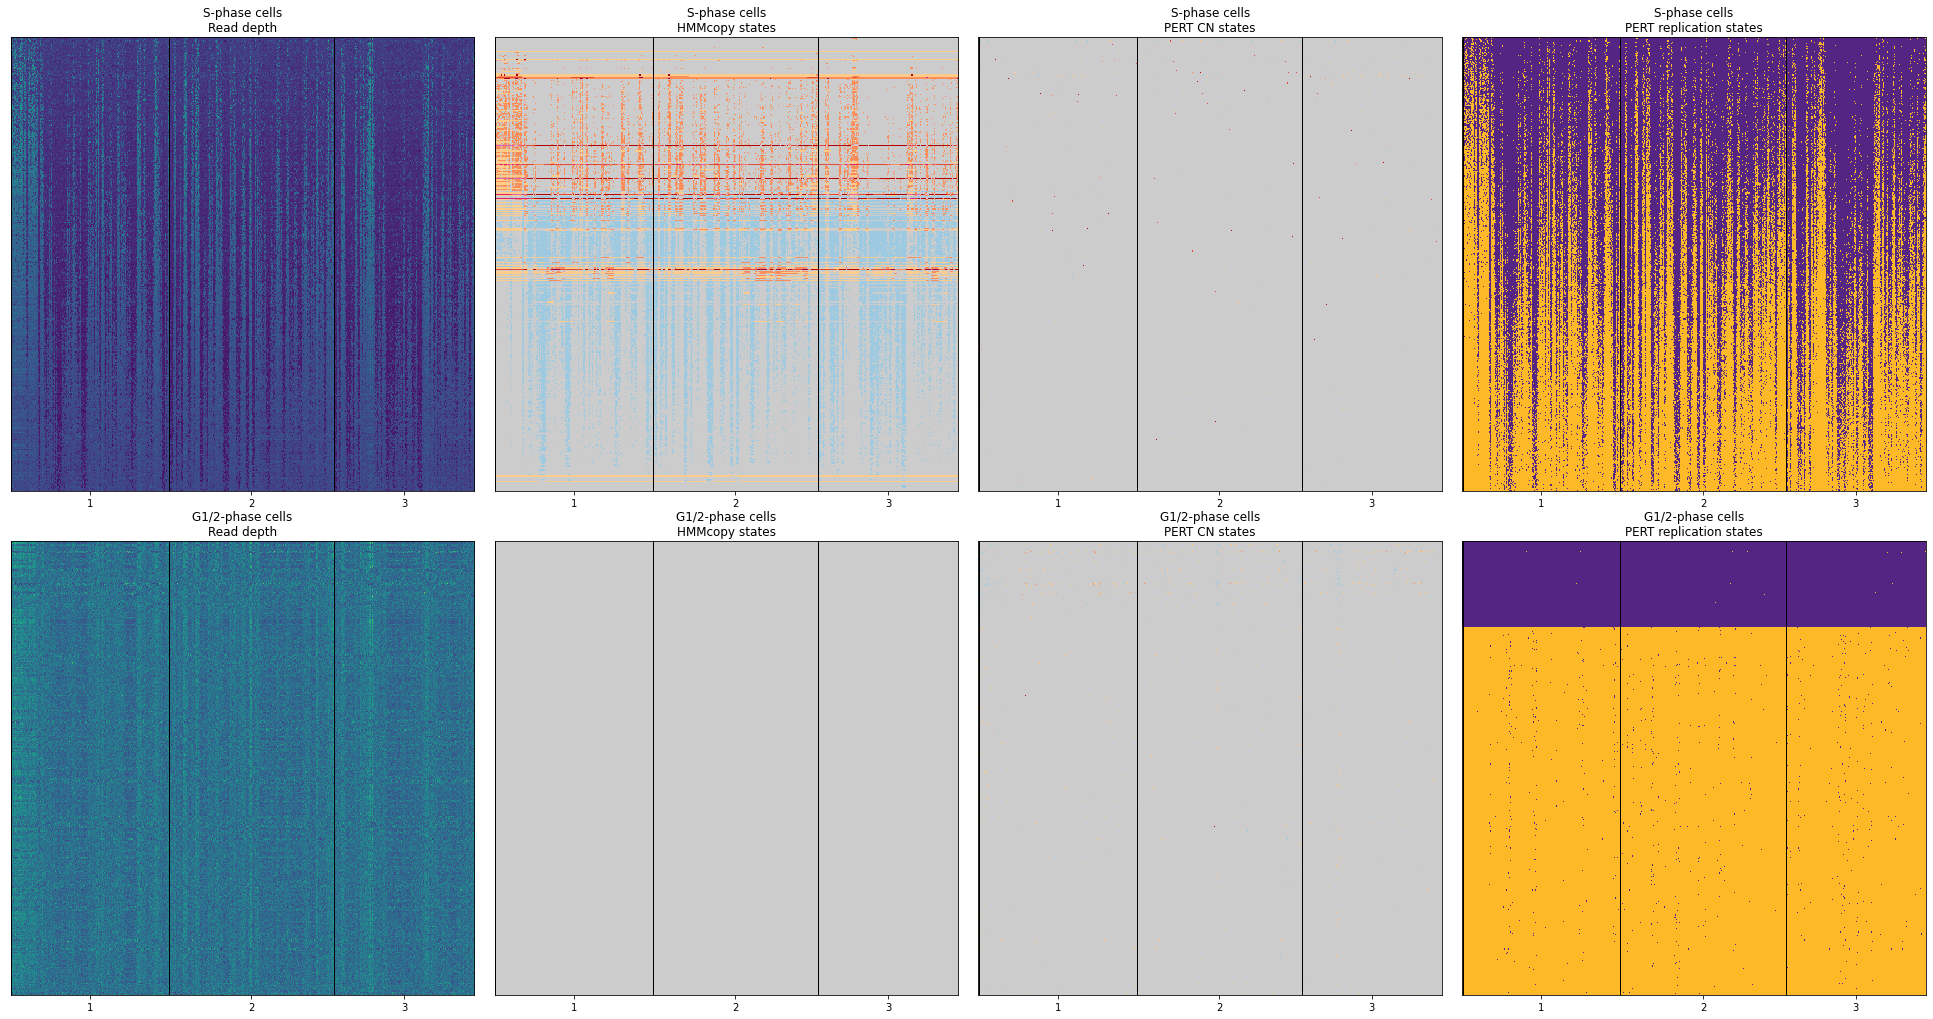

In [11]:
# plot the results of the inference
plot_model_results(
    cn_s_with_scrt, cn_g_with_scrt, clone_col='clone_id', second_sort_col='model_tau',
    input_cn_col='state', output_cn_col='model_cn_state', output_rep_col='model_rep_state',
    rpm_col='true_reads_norm', rpm_title='Read depth', input_cn_title='HMMcopy states',
    output_cn_title='PERT CN states', rep_title='PERT replication states'
)
plt.show()